<a href="https://colab.research.google.com/github/aahFancyGun/dataScienceClass/blob/master/unit4/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [32]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}

with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 30)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 30)
    μ_nu = pm.HalfStudentT('μ_nu', sigma=10, nu = 30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  nu = μ_nu,
                  sigma=μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 30,
                      sigma = 10,
                      dims = "aa")

    v=pm.HalfStudentT('v', nu = 30, sigma = 10, dims='aa')

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = v[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()


Output()

Output()

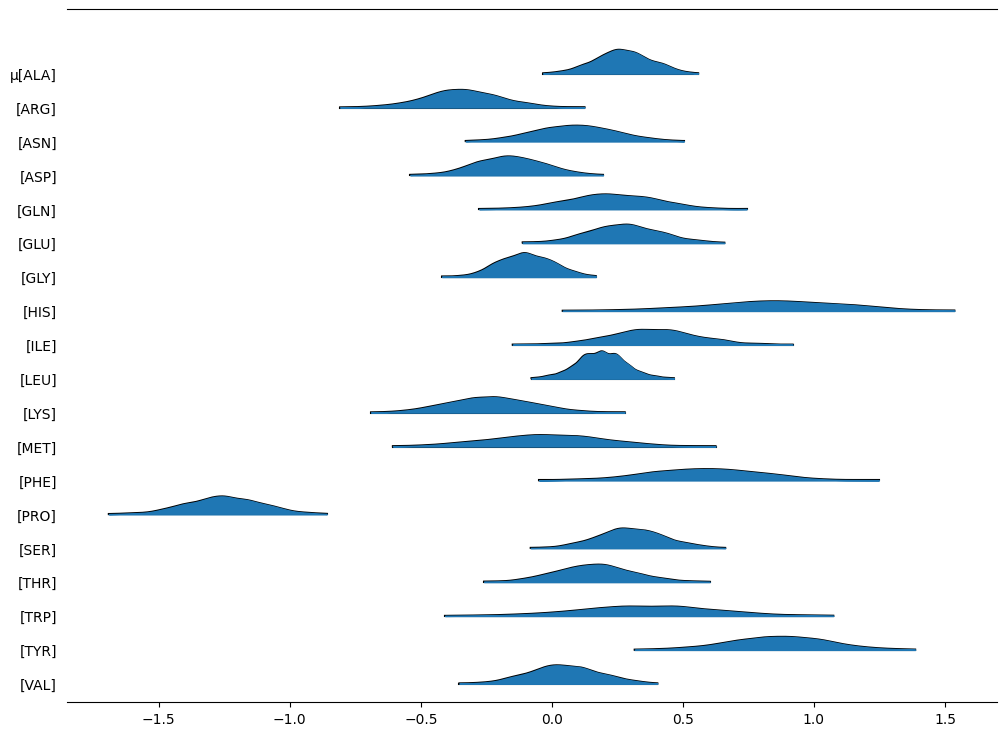

In [3]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)



In [21]:
with pm.Model(coords=aa_coords) as cs_hh_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hh = pm.sample()

Output()

Output()

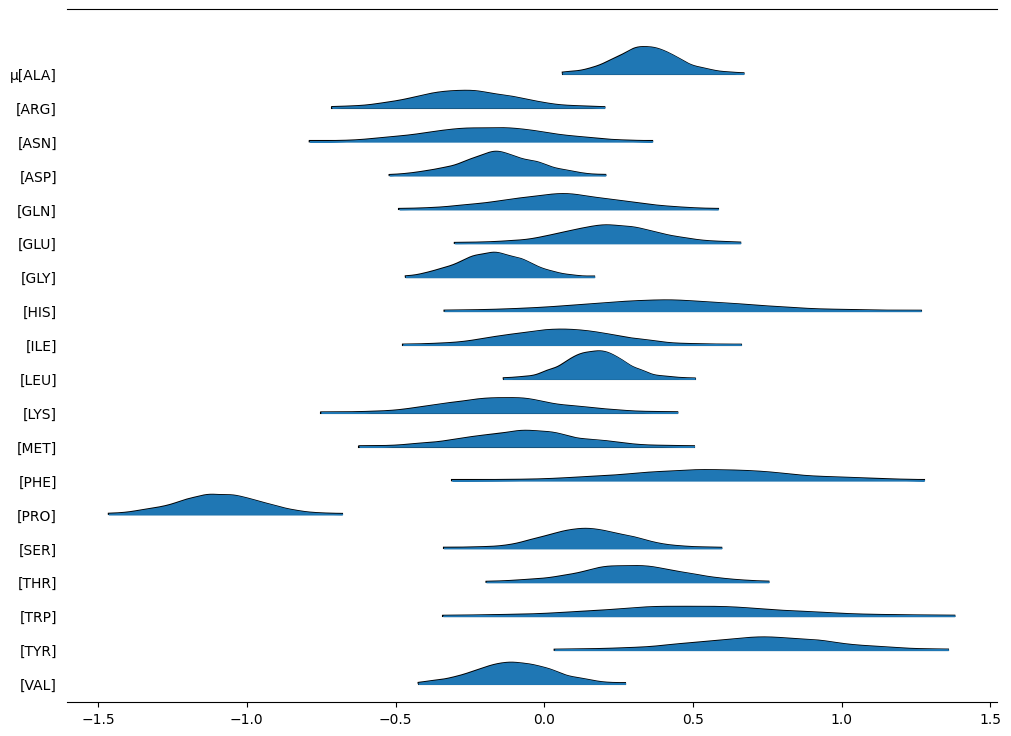

In [5]:
axes = az.plot_forest(idata_cs_hh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Student T as a whole seems to be shifted to the left in comparison to the NormalHierarchical model. So on the right side of the origin about 0, Student T represents a more accurate model to as its closer to 0 but on the left, the normal model beats it. Because of this, I can't really make any conclusion about which one is more accurate.

The posterior predictive check however, tells a different story. Looking at the distribution of predicts made by both models we can see that studentT is actually marginally better compared to normal. The normal model lines up with observed data reasonably well but diverges near the peak and overshoots. Contrastingly, studentT matches the peak far more effectively.

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data


Output()

array([<Axes: xlabel='y'>], dtype=object)

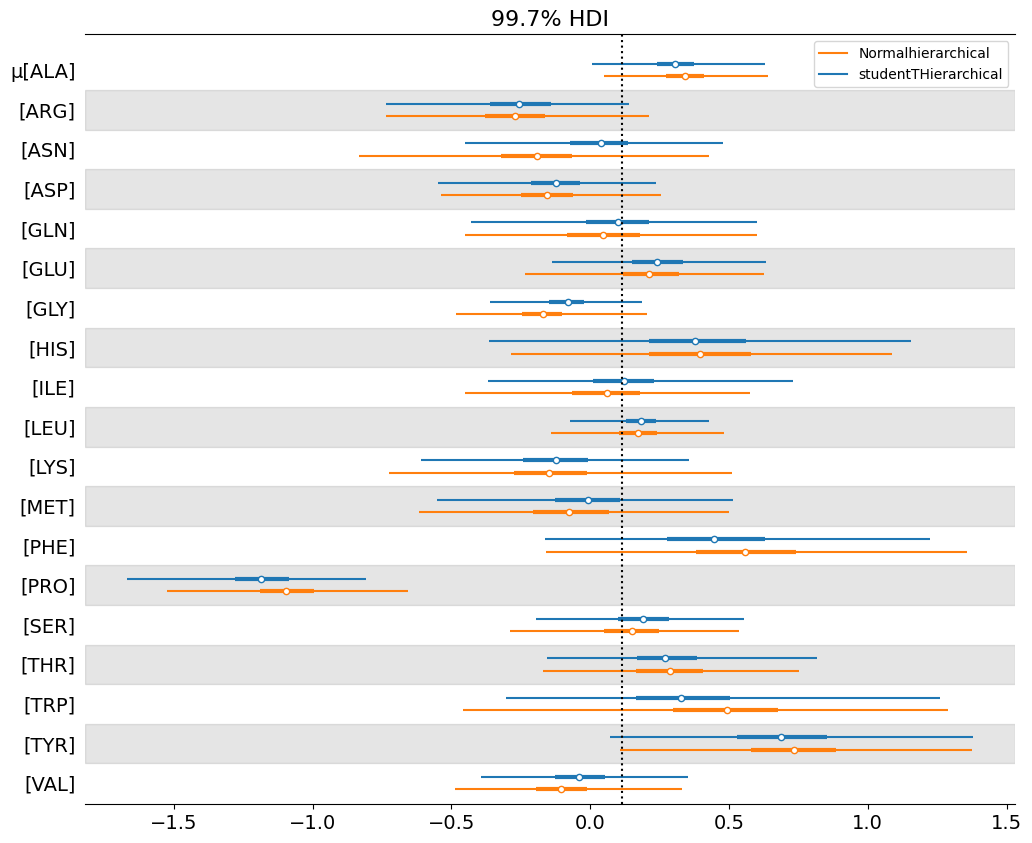

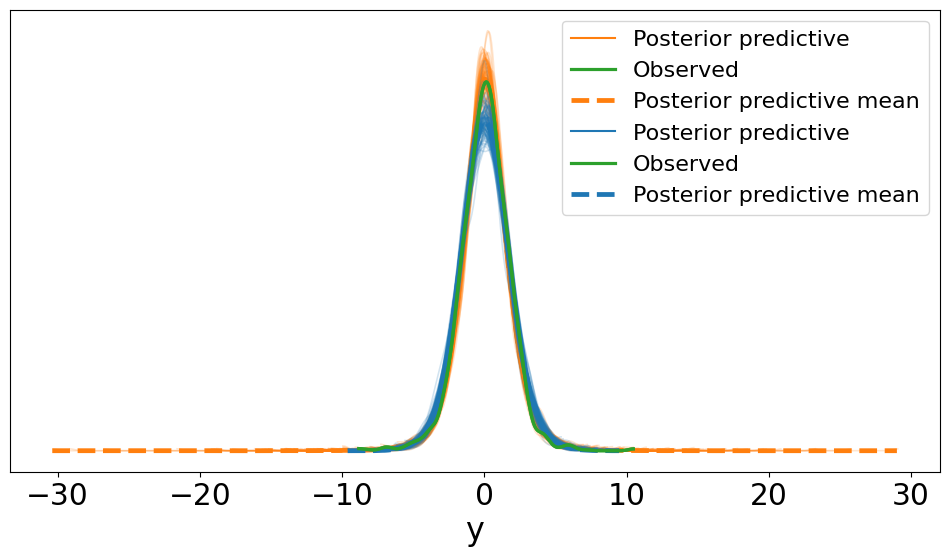

In [36]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_h, idata_cs_hh], kind="forestplot",
                      model_names=['studentTHierarchical', 'Normalhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

fig, ax = plt.subplots(figsize=(12, 6))

print(idata_cs_h)
print(idata_cs_hh)

pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
pm.sample_posterior_predictive(idata_cs_hh, model=cs_hh_model, extend_inferencedata=True)



az.plot_ppc(idata_cs_h, ax=ax, num_pp_samples=100, figsize=(12, 6), colors=["C1", "C2", "C1"], legend = True)
#studentT
az.plot_ppc(idata_cs_hh, ax=ax, num_pp_samples=100, figsize=(12, 6), colors=["C0", "C2", "C0"],legend = True)
#normal



**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [7]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [8]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [9]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 0.1, nu = 45, dims = 'pos')

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims = 'pos')

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

Similar to the heirarchical model, there appears to be an anomaly in the goalkeeper's position. Additionally, there seem to be signific differences in the nu between the two models. You can notice that the non-hierarchical model goes past the orange line at several points but the heirarchical model stays below the orange line.

In [10]:
az.rhat(idata_sccr_nh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.002 1.0 0.9999 ... 0.9996 0.9999 1.003
    μ_p      (pos) float64 32B 1.003 1.001 1.021 1.003
    ν_p      (pos) float64 32B 1.025 1.0 1.113 1.005

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

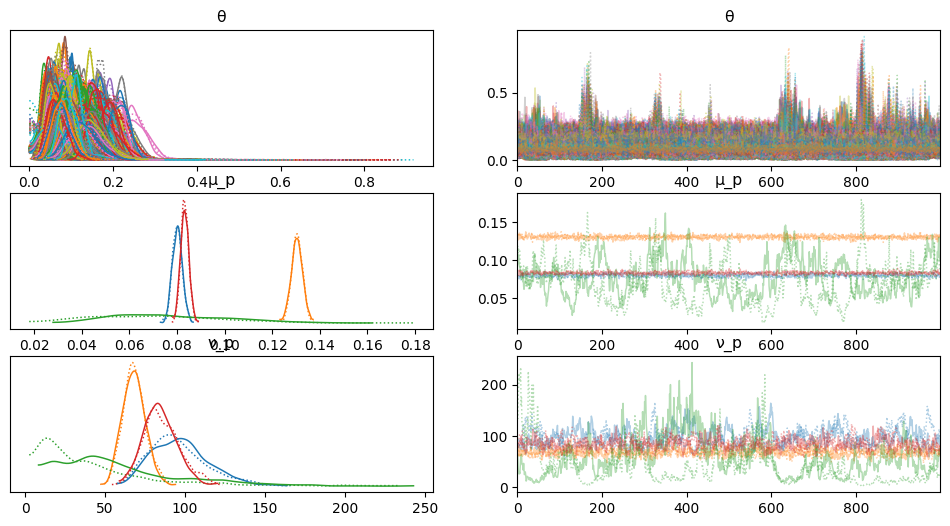

In [11]:
az.plot_trace(idata_sccr_nh)

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

Because its not hierarchical, it has no shrinkage because there are no hyperpriors. This constitutes the main difference between this model and the hierrchical model  with the range of each poisition ranging from 0.02 to 0.16 as opposed to 0.02 to 0.14. Notably, the biggest change appears to be the goalkeeper position, which has become wider despite the fact that the other positions appear to have remained relatively the same compared to how they appear in the hierarchical model.

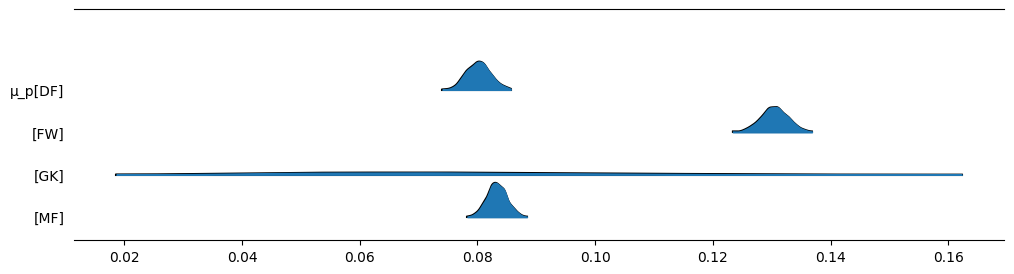

In [27]:
axes = az.plot_forest(idata_sccr_nh, kind="ridgeplot",
                      var_names='μ_p',
                      combined=True, figsize=(12, 3), hdi_prob=0.997)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [14]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr)

sccr_data = sccr_data[sccr_data['position'] != 'GK'].astype({'position': 'category'})


In [15]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [16]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

1. I believe that the model with out gk would've been easier for pymc to process simply because there wouldve been less data points to pay attention to. So naturally, the model that has to deal with additional datapoints will generate slower. Interestingly, because this model is being used to predict goals scored, the GK (a position that is astronomically unlikely to score any goals) could be argued to be irrelevant data, meaning that not only do we decrease the processing time, but also the accuracy.

2. By dropping GK we gain processing speed, and no longer experience an anomaly with rhat, but we stand to lose accuracy in our model as it no longer takes into account potentially relevant data when making its prediction. Additionally, when looking at rhat, there still appears to be some anomalies that stray outside the 1 - 1.001 range. The biggest change however, comes when we look at the tracing, which reveals that most of the graphs look completely different from their counterparts further up.

In [17]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 0.9994 1.003 ... 1.002 1.002 1.001
    μ        float64 8B 1.0
    μ_p      (pos) float64 24B 1.003 1.002 1.004
    ν        float64 8B 1.001
    ν_p      (pos) float64 24B 1.012 1.001 1.012

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

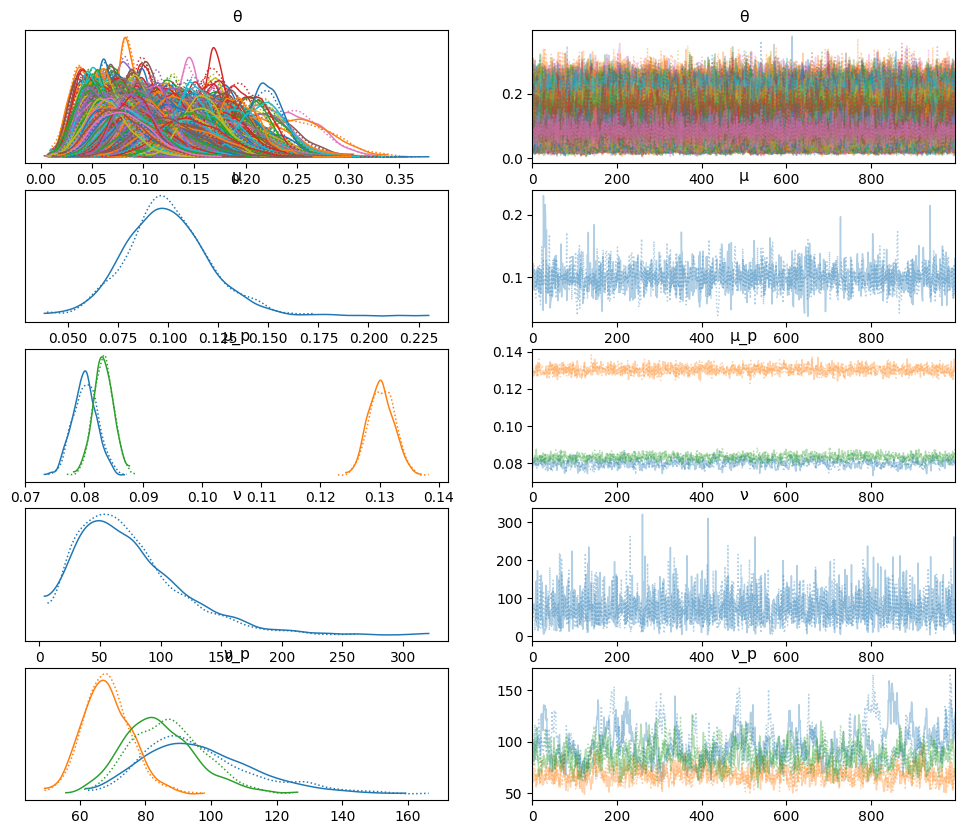

In [18]:
az.plot_trace(idata_sccr)